# A Learning-based Model for Assessment of Recurrent Abortion
## Import library, define some useful function

In [2]:
# basic
import warnings
import pickle
import json
from functools import partial
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

# classifiers
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# spliting
from sklearn.model_selection import train_test_split, StratifiedKFold

# metrics
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix

# statistical tools
from scipy.stats import shapiro, mannwhitneyu, chi2_contingency

# visualization
from IPython.display import display, IFrame,Image
import shap
import tensorboardX
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline
sns.set(style="whitegrid", context="paper", font="sans-serif",
        rc={'figure.figsize': (5, 5), 'figure.dpi': 1200, "font.size": 12, "axes.titlesize": 11,
            "axes.labelsize": 10})

# fix random seed for reproducebility
SEED=8888

# it takes some time to run cross validation, turn off if you don't need it
RUN_CV_RESULT = True
CV_RESULT_REPEAT = 25

VAR_NUM = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

COMPARED_METHOD = [
    "XGBoost",
    "Logistic",
    "Random Forest",
    "SVM",
    "Decision Tree",
    "LDA"
]

# variables
VARS_ALL = \
    {
        "num": ['Age', 'BMI', 'E2', 'P', 'APTT', 'FT3', 'FT4', 'ACA-IgM', 'Ab anti-β2 GP1', 'Protein S', 'D-DI'],
        
        "cate": ['T', 'TSH', 'TT3', 'EMAb', 'AoAb', 'Maternal chromosome', 'Blood Type（ABO)A_B_AB_O','Blood Type（ABO)AB_Abn']
    }

# compared METHODS
METHODS = [
    {
        "name": "XGBoost",
        "hyper_parameters": {'alpha': 4.0, 'colsample_bytree': 0.9, 'eta': 0.25, 'gamma': 1, 'lambda': 2,
                             'max_depth': 8, 'min_child_weight': 7.0, 'scale_pos_weight': 20.0,
                             'subsample': 0.9,
                             'n_estimators': 120,"random_state":SEED},
        "classifier": XGBClassifier
    },
    {
        "name": "FeatureImportance",
        "hyper_parameters": {'max_depth': 4, 'learning_rate': 0.2, 'reg_lambda': 1, 'n_estimators': 150,
                             'subsample': 0.9, "colsample_bytree": 0.9},
        "classifier": XGBClassifier
    },
    {
        "name": "Logistic",
        "hyper_parameters": {
            "penalty": 'l2'},
        "classifier": LogisticRegression
    },
    {
        "name": "Random Forest",
        "hyper_parameters": {"criterion": "entropy"},
        "classifier": RandomForestClassifier
    },
    {
        "name": "SVM",
        "hyper_parameters": {"kernel": "rbf"},
        "classifier": SVC
    },
    {
        "name": "Decision Tree",
        "hyper_parameters": {'max_depth': 3, 'n_estimators': 1},
        "classifier": XGBClassifier
    },
    {
        "name": "LDA",
        "hyper_parameters": {},
        "classifier": LinearDiscriminantAnalysis
    },

]

# utility functions
sensitivity=lambda y_true, y_pred:classification_report(y_true, y_pred, output_dict=True, target_names=["Non_Server", "Server"])["Server"]["recall"]
specifity=lambda y_true, y_pred:classification_report(y_true, y_pred, output_dict=True, target_names=["Non_Server", "Server"])["Non_Server"]["recall"]
TN=lambda y_true, y_pred:confusion_matrix(y_true, y_pred).ravel()[0]
FP=lambda y_true, y_pred:confusion_matrix(y_true, y_pred).ravel()[1]
FN=lambda y_true, y_pred:confusion_matrix(y_true, y_pred).ravel()[2]
TP=lambda y_true, y_pred:confusion_matrix(y_true, y_pred).ravel()[3]
def q25(x):
    return np.quantile(x, q=0.25)
def q75(x):
    return np.quantile(x, q=0.75)


# compared metrics
MY_METRICS = {
    # commented metrics not used because of limited space and selected metrics are sufficient to estimate the performance

    # "F1_binary": partial(f1_score, average="binary"),
    # "F1_macro": partial(f1_score, average="macro"),
    "F1_weighted": partial(f1_score, average="weighted"), 
    # "Precision_binary": partial(precision_score, average="binary"),
    # "Precision_macro": partial(precision_score, average="macro"),
    # "Precision_weighted": partial(precision_score, average="weighted"),
    # "Recall_binary": partial(recall_score, average="binary"),
    # "Recall_macro": partial(recall_score, average="macro"),
    # "Recall_weighted": partial(recall_score, average="weighted"),
    "Accuracy": accuracy_score,
    "Sensitivity": sensitivity,
    "Specifity": specifity,
    "tn": TN,
    "fp": FP,
    "fn": FN,
    "tp": TP,
}

# METHODS of which AUC can be calculated
HAVE_AUC_METHOD = [
    "XGBoost",
    "Logistic",
    "Random Forest",
    "Decision Tree",
    "LDA"]


## Loading data


In [4]:

# load dataset
dataset = pd.read_excel("./FOR CODE-V6.0.xlsx", convert_float=False)
# dataset = dataset.drop(['编号', '门诊号', 'BA', '姓名', '电话', '时间'],axis=1)
for i in list(dataset.columns):
    if dataset[i].dtypes == 'object':
        dataset[i] = pd.to_numeric(dataset[i], errors='coerce')
print(dataset.info())
# print(dataset.columns)
# dataset_non_tranmit = dataset[dataset.non_severe_to_severe != 1]
y = "Parturition"
ALL_X = [*VARS_ALL["num"], *VARS_ALL["cate"]]
# make table_1 to show statistics
table_1 = pd.DataFrame()
for var in VARS_ALL["num"]:
    t ={}
    t["var"] = var
    t["support"] = len(dataset[var].dropna())
    t["mean"] = dataset[var].astype(float).dropna().mean()
    t["std"] = dataset[var].astype(float).dropna().std()
    table_1 = table_1.append(t,ignore_index=True)

for var in VARS_ALL["cate"]:
    t = {}
    t["var"] = var
    t["support"] = len(dataset[[var,y]].dropna())
    print(var)
    print(dataset[[var,y]].dropna()[var].unique())
    for cat in list(dataset[[var,y]].dropna()[var].unique()):
        t[str(int(cat))] = len(dataset[[var,y]].dropna()[dataset[[var,y]].dropna()[var]==1])
        t[str(int(cat)) + 'ratio'] = t[str(int(cat))] / len(dataset[[var,y]])
    table_1 = table_1.append(t,ignore_index=True)
display(table_1)
table_1.to_csv("./Table_1.csv", encoding="utf_8_sig")
print("finished")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Parturition              1875 non-null   float64
 1   Age                      1859 non-null   float64
 2   BMI                      1836 non-null   float64
 3   E2                       929 non-null    float64
 4   P                        840 non-null    float64
 5   T                        881 non-null    float64
 6   TSH                      1719 non-null   float64
 7   TT3                      1444 non-null   float64
 8   FT3                      1690 non-null   float64
 9   FT4                      1690 non-null   float64
 10  EMAb                     1778 non-null   float64
 11  AoAb                     1747 non-null   float64
 12  ACA-IgM                  694 non-null    float64
 13  Ab anti-β2 GP1           689 non-null    float64
 14  Protein S               

,mean,std,support,var,0,0ratio,1,1ratio,2,2ratio,3,3ratio
0,30.537924,4.516807,1859.0,Age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21.485938,3.174804,1836.0,BMI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,65.309957,71.390897,929.0,E2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.490660,6.612822,840.0,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,34.566644,10.448754,1466.0,APTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5.115624,3.850132,1690.0,FT3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10.921239,2.692879,1690.0,FT4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.189035,4.877363,694.0,ACA-IgM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.107128,5.909260,689.0,Ab anti-β2 GP1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,78.043977,32.026510,1368.0,Protein S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Missing Value


,Number of Observations,Number of Variables,Thresh alpha
0,107.0,20.0,0.0
1,107.0,20.0,1.0
2,107.0,20.0,2.0
3,107.0,20.0,3.0
4,107.0,20.0,4.0
...,...,...,...
1870,1875.0,1.0,1870.0
1871,1875.0,1.0,1871.0
1872,1875.0,1.0,1872.0
1873,1875.0,1.0,1873.0


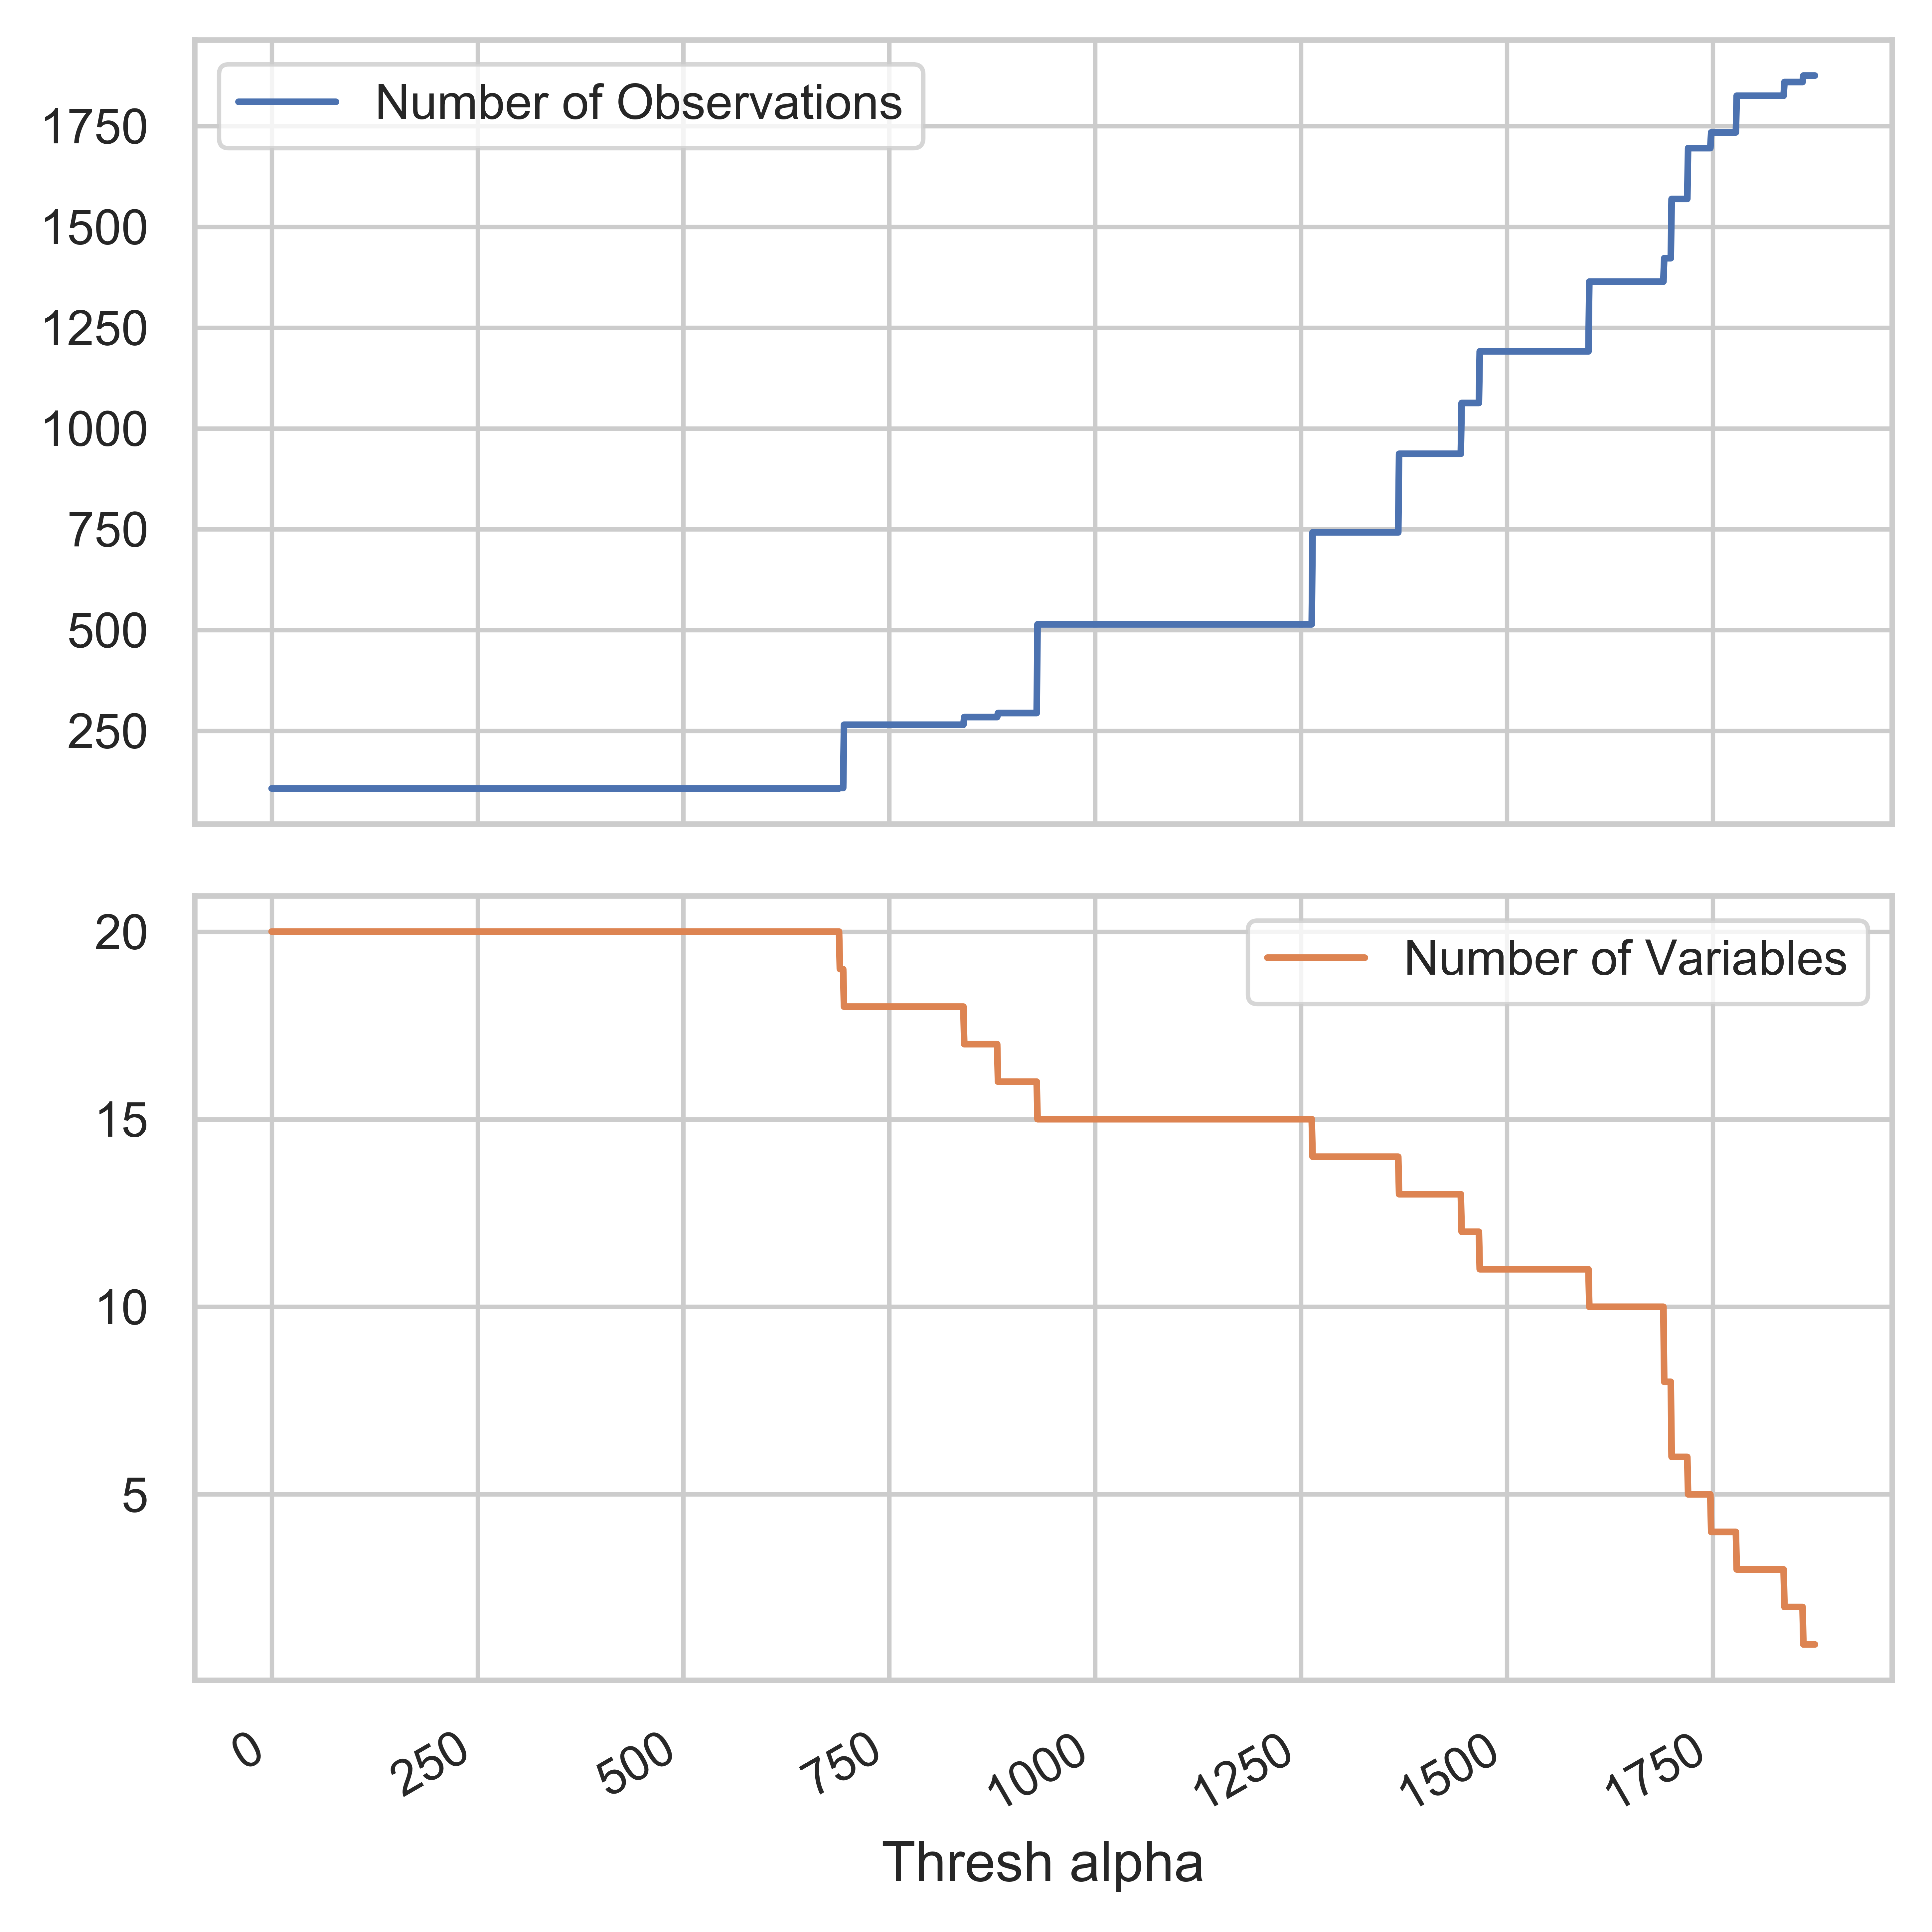

In [5]:
# show the relationship between included variables and available observations
obs_vars_alpha = pd.DataFrame()
for i in range(1875):
    t = dataset[[*ALL_X, y]].dropna(axis="columns", thresh=i).dropna()
    obs_vars_alpha = obs_vars_alpha.append(
        {
            "Thresh alpha": i,
            "Number of Observations": len(t),
            "Number of Variables": len(t.columns)
        }, ignore_index=True)
display(obs_vars_alpha)
obs_vars_alpha.plot(x="Thresh alpha", y=["Number of Observations", "Number of Variables"], subplots=True)
plt.tight_layout()
# plt.show()
plt.savefig("./Figure_alpha_selection.png")
# Image(filename="./paper/Supplementary_Figure_2.png")
# plt.clf()
# plt.close()


In [6]:
# remove missing value
display(obs_vars_alpha[820:870])
THRESHOLD_ALPHA=1699# the THRESHOLD_ALPHA is determined from above figure
VARS_REMOVED_MISSING={}
t = dataset[[*ALL_X, y]].dropna(axis="columns", thresh=THRESHOLD_ALPHA).dropna()
t = t.loc[:, (t != 0).any(axis=0)].loc[:, (t != False).any(axis=0)].loc[:, (t != True).any(axis=0)]
dataset_removing_missing_value=t
display(dataset_removing_missing_value)
dataset_removing_missing_value.to_csv("./dataset_remove_missing_value_thresh_{}.csv".format(THRESHOLD_ALPHA), encoding="utf_8_sig")

VARS_REMOVED_MISSING["num"] = []
VARS_REMOVED_MISSING["cate"] = []
for i in VARS_ALL["num"]:
    if i in list(dataset_removing_missing_value.columns):
        VARS_REMOVED_MISSING["num"].append(i)

for i in VARS_ALL["cate"]:
    if i in list(dataset_removing_missing_value.columns):
        VARS_REMOVED_MISSING["cate"].append(i)

display(VARS_REMOVED_MISSING)


,Number of Observations,Number of Variables,Thresh alpha
820,265.0,18.0,820.0
821,265.0,18.0,821.0
822,265.0,18.0,822.0
823,265.0,18.0,823.0
824,265.0,18.0,824.0
825,265.0,18.0,825.0
826,265.0,18.0,826.0
827,265.0,18.0,827.0
828,265.0,18.0,828.0
829,265.0,18.0,829.0


,Age,BMI,TSH,EMAb,AoAb,Blood Type（ABO)A_B_AB_O,Blood Type（ABO)AB_Abn,Parturition
0,24.0,16.343535,0.0,0.0,0.0,0.0,1.0,1.0
1,27.0,18.289895,0.0,0.0,0.0,3.0,1.0,1.0
2,36.0,21.359306,0.0,0.0,0.0,2.0,0.0,1.0
3,35.0,20.507812,0.0,0.0,0.0,1.0,1.0,0.0
4,25.0,21.499597,0.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
1869,34.0,21.258503,0.0,0.0,1.0,3.0,1.0,1.0
1870,30.0,22.265625,0.0,0.0,0.0,1.0,1.0,0.0
1871,27.0,18.144869,0.0,1.0,1.0,2.0,0.0,1.0
1872,27.0,33.057851,0.0,0.0,0.0,0.0,1.0,0.0


{'num': ['Age', 'BMI'],
 'cate': ['TSH',
  'EMAb',
  'AoAb',
  'Blood Type（ABO)A_B_AB_O',
  'Blood Type（ABO)AB_Abn']}

## Univariant Statistical Test

In [30]:
# normalty test
normalty_test_result=pd.DataFrame()
for var in dataset_removing_missing_value.columns:
    if var in VARS_REMOVED_MISSING["num"]:
        p_value = shapiro(dataset_removing_missing_value[[var, y]].dropna().astype(float))[1]
        normalty_test_result=normalty_test_result.append(
            {
                "var":var,
                "pvalue":p_value,
                "is_normal":p_value<0.05,
                "num_not_nan":len(dataset_removing_missing_value[[var, y]].dropna().astype(float))
            },ignore_index=True)
print(len(VARS_REMOVED_MISSING["num"]))
print(VARS_REMOVED_MISSING["num"])
display(normalty_test_result)
if len(normalty_test_result)==len(normalty_test_result[normalty_test_result.is_normal==True]):
    print("all_normal")


9
['Age', 'BMI', 'E2', 'P', 'APTT', 'FT3', 'FT4', 'Protein S', 'D-DI']
all_normal


,is_normal,num_not_nan,pvalue,var
0,1.0,265.0,1.557031e-26,Age
1,1.0,265.0,4.219582e-26,BMI
2,1.0,265.0,4.835363e-36,E2
3,1.0,265.0,5.300327e-40,P
4,1.0,265.0,1.487232e-32,APTT
5,1.0,265.0,2.842129e-23,FT3
6,1.0,265.0,1.392654e-25,FT4
7,1.0,265.0,3.216165e-24,Protein S
8,1.0,265.0,6.341411e-29,D-DI


In [31]:
# mannwhitneyu-test
uni_test_result = pd.DataFrame()
for var in VARS_REMOVED_MISSING["num"]:
    t = dataset_removing_missing_value[[var, y]].dropna()
    give_birth = t[t[y] == 1][var]
    non_give_birth = t[t[y] == 0][var]
    uni_test_result = uni_test_result.append(
        {"var": var,
         "pvalue": mannwhitneyu(give_birth, non_give_birth)[1],
         "give_birth_mean": give_birth.mean(),
         "give_birth_std": give_birth.std(),
         "non_give_birth_mean": non_give_birth.mean(),
         "non_give_birth_std": non_give_birth.std(),
         "give_birth_count": len(give_birth),
         "non_give_birth_count": len(non_give_birth)
         }
        , ignore_index=True
    )

In [32]:
# chi2test
for var in VARS_REMOVED_MISSING["cate"]:
    ct = pd.crosstab(dataset_removing_missing_value[y], dataset_removing_missing_value[var], margins=True, dropna=True)
    uni_test_result = uni_test_result.append(
        {"var": var,
         "pvalue": chi2_contingency(ct)[1],
         "give_birth_mean": 0,
         "give_birth_std": -1, # indicate it's category variable
         "non_give_birth_mean": 0,
         "non_give_birth_std": 0,
         "give_birth_count": ct.iloc[1, 2] if len(ct.columns) > 1 else 0,
         "non_give_birth_count": ct.iloc[0, 2]
         }
        , ignore_index=True
    )
display(uni_test_result)
uni_test_result.to_csv("./uni_test_result.csv", encoding="utf_8_sig")
significant_vars=uni_test_result[uni_test_result.pvalue<=0.05].sort_values(axis=0, ascending=True, by='pvalue')
display(significant_vars["var"].tolist())


,give_birth_count,give_birth_mean,give_birth_std,non_give_birth_count,non_give_birth_mean,non_give_birth_std,pvalue,var
0,171.0,29.801170,4.513535,94.0,30.808511,5.029540,0.049998,Age
1,171.0,21.553513,3.035838,94.0,22.463578,4.209380,0.067648,BMI
2,171.0,57.767018,51.351244,94.0,66.868511,91.310325,0.335816,E2
3,171.0,1.598380,3.301974,94.0,0.960213,1.307404,0.109555,P
4,171.0,36.003509,20.855785,94.0,34.126596,8.264800,0.217232,APTT
5,171.0,5.014327,0.735498,94.0,5.061596,0.615798,0.248724,FT3
6,171.0,11.229181,1.703861,94.0,11.029574,1.911908,0.383733,FT4
7,171.0,77.837661,29.450718,94.0,75.202128,25.365072,0.295657,Protein S
8,171.0,84.693450,62.179647,94.0,84.110638,69.086804,0.398523,D-DI
9,171.0,0.000000,-1.000000,94.0,0.000000,0.000000,0.907254,T


['Age']

## Benchmark


In [7]:
# set
# VARS_REMOVED_MISSING_SIGNIFICANT={
#     'num': ['年龄', '孕次', '产次', '色谱法同型半胱氨酸测定', '剖宫产次', '自然流产次数', '顺产次'],
#     'cate': []}
VARS_REMOVED_MISSING_SIGNIFICANT=VARS_REMOVED_MISSING
# normalization
for i in VARS_REMOVED_MISSING_SIGNIFICANT["num"]:
    dataset_removing_missing_value[i] = (dataset_removing_missing_value[i] - dataset_removing_missing_value[i].mean()) / dataset_removing_missing_value[i].std()

SIGNIFICANT_X = [*VARS_REMOVED_MISSING_SIGNIFICANT["num"], *VARS_REMOVED_MISSING_SIGNIFICANT["cate"]]
X_train, X_test, y_train, y_test = train_test_split(dataset_removing_missing_value[SIGNIFICANT_X], dataset_removing_missing_value[[y]], test_size=0.3, stratify=dataset_removing_missing_value[[y]],
                                                    random_state=SEED)

### Feature importance


In [8]:
# feature importance
# use short name for display in figure
FEATURE_NAME_MAPPING = {
   'Age': 'Age', 'BMI':'BMI', 'TSH':'TSH','EMAb':'EMAb', 
    'AoAb': 'AoAb','Blood Type（ABO)A_B_AB_O':'Blood Type（ABO)A_B_AB_O',
    'Blood Type（ABO)AB_Abn':'Blood Type（ABO)AB_Abn'}
feature_importance = pd.DataFrame()
feature_importance['Variables_name'] = SIGNIFICANT_X
feature_importance["Variables"]=[FEATURE_NAME_MAPPING[i] for i in SIGNIFICANT_X]
feature_importance['Importance'] = 0

for i in range(100):
    classifier = XGBClassifier(**METHODS[1]["hyper_parameters"],random_state=SEED+i)
    t_X_train, _, t_y_train, _ = train_test_split(X_train, y_train, test_size=0.3,
                                                  random_state=SEED + i)
    classifier.fit(t_X_train, t_y_train)
    shap_values = shap.TreeExplainer(classifier).shap_values(t_X_train[SIGNIFICANT_X], y=t_y_train[y], check_additivity=True)
    mean_shap = abs(shap_values).mean(0)
    feature_importance['Importance'] = feature_importance['Importance'] + mean_shap / 100

feature_importance = feature_importance.sort_values(axis=0, ascending=False, by='Importance')
display(feature_importance)
feature_importance.to_csv("./feature_importance.csv")


[19:34:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:34:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:34:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:34:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,Variables_name,Variables,Importance
1,BMI,BMI,0.766362
0,Age,Age,0.495662
5,Blood Type（ABO)A_B_AB_O,Blood Type（ABO)A_B_AB_O,0.227657
2,TSH,TSH,0.097113
4,AoAb,AoAb,0.093339
6,Blood Type（ABO)AB_Abn,Blood Type（ABO)AB_Abn,0.079421
3,EMAb,EMAb,0.078141


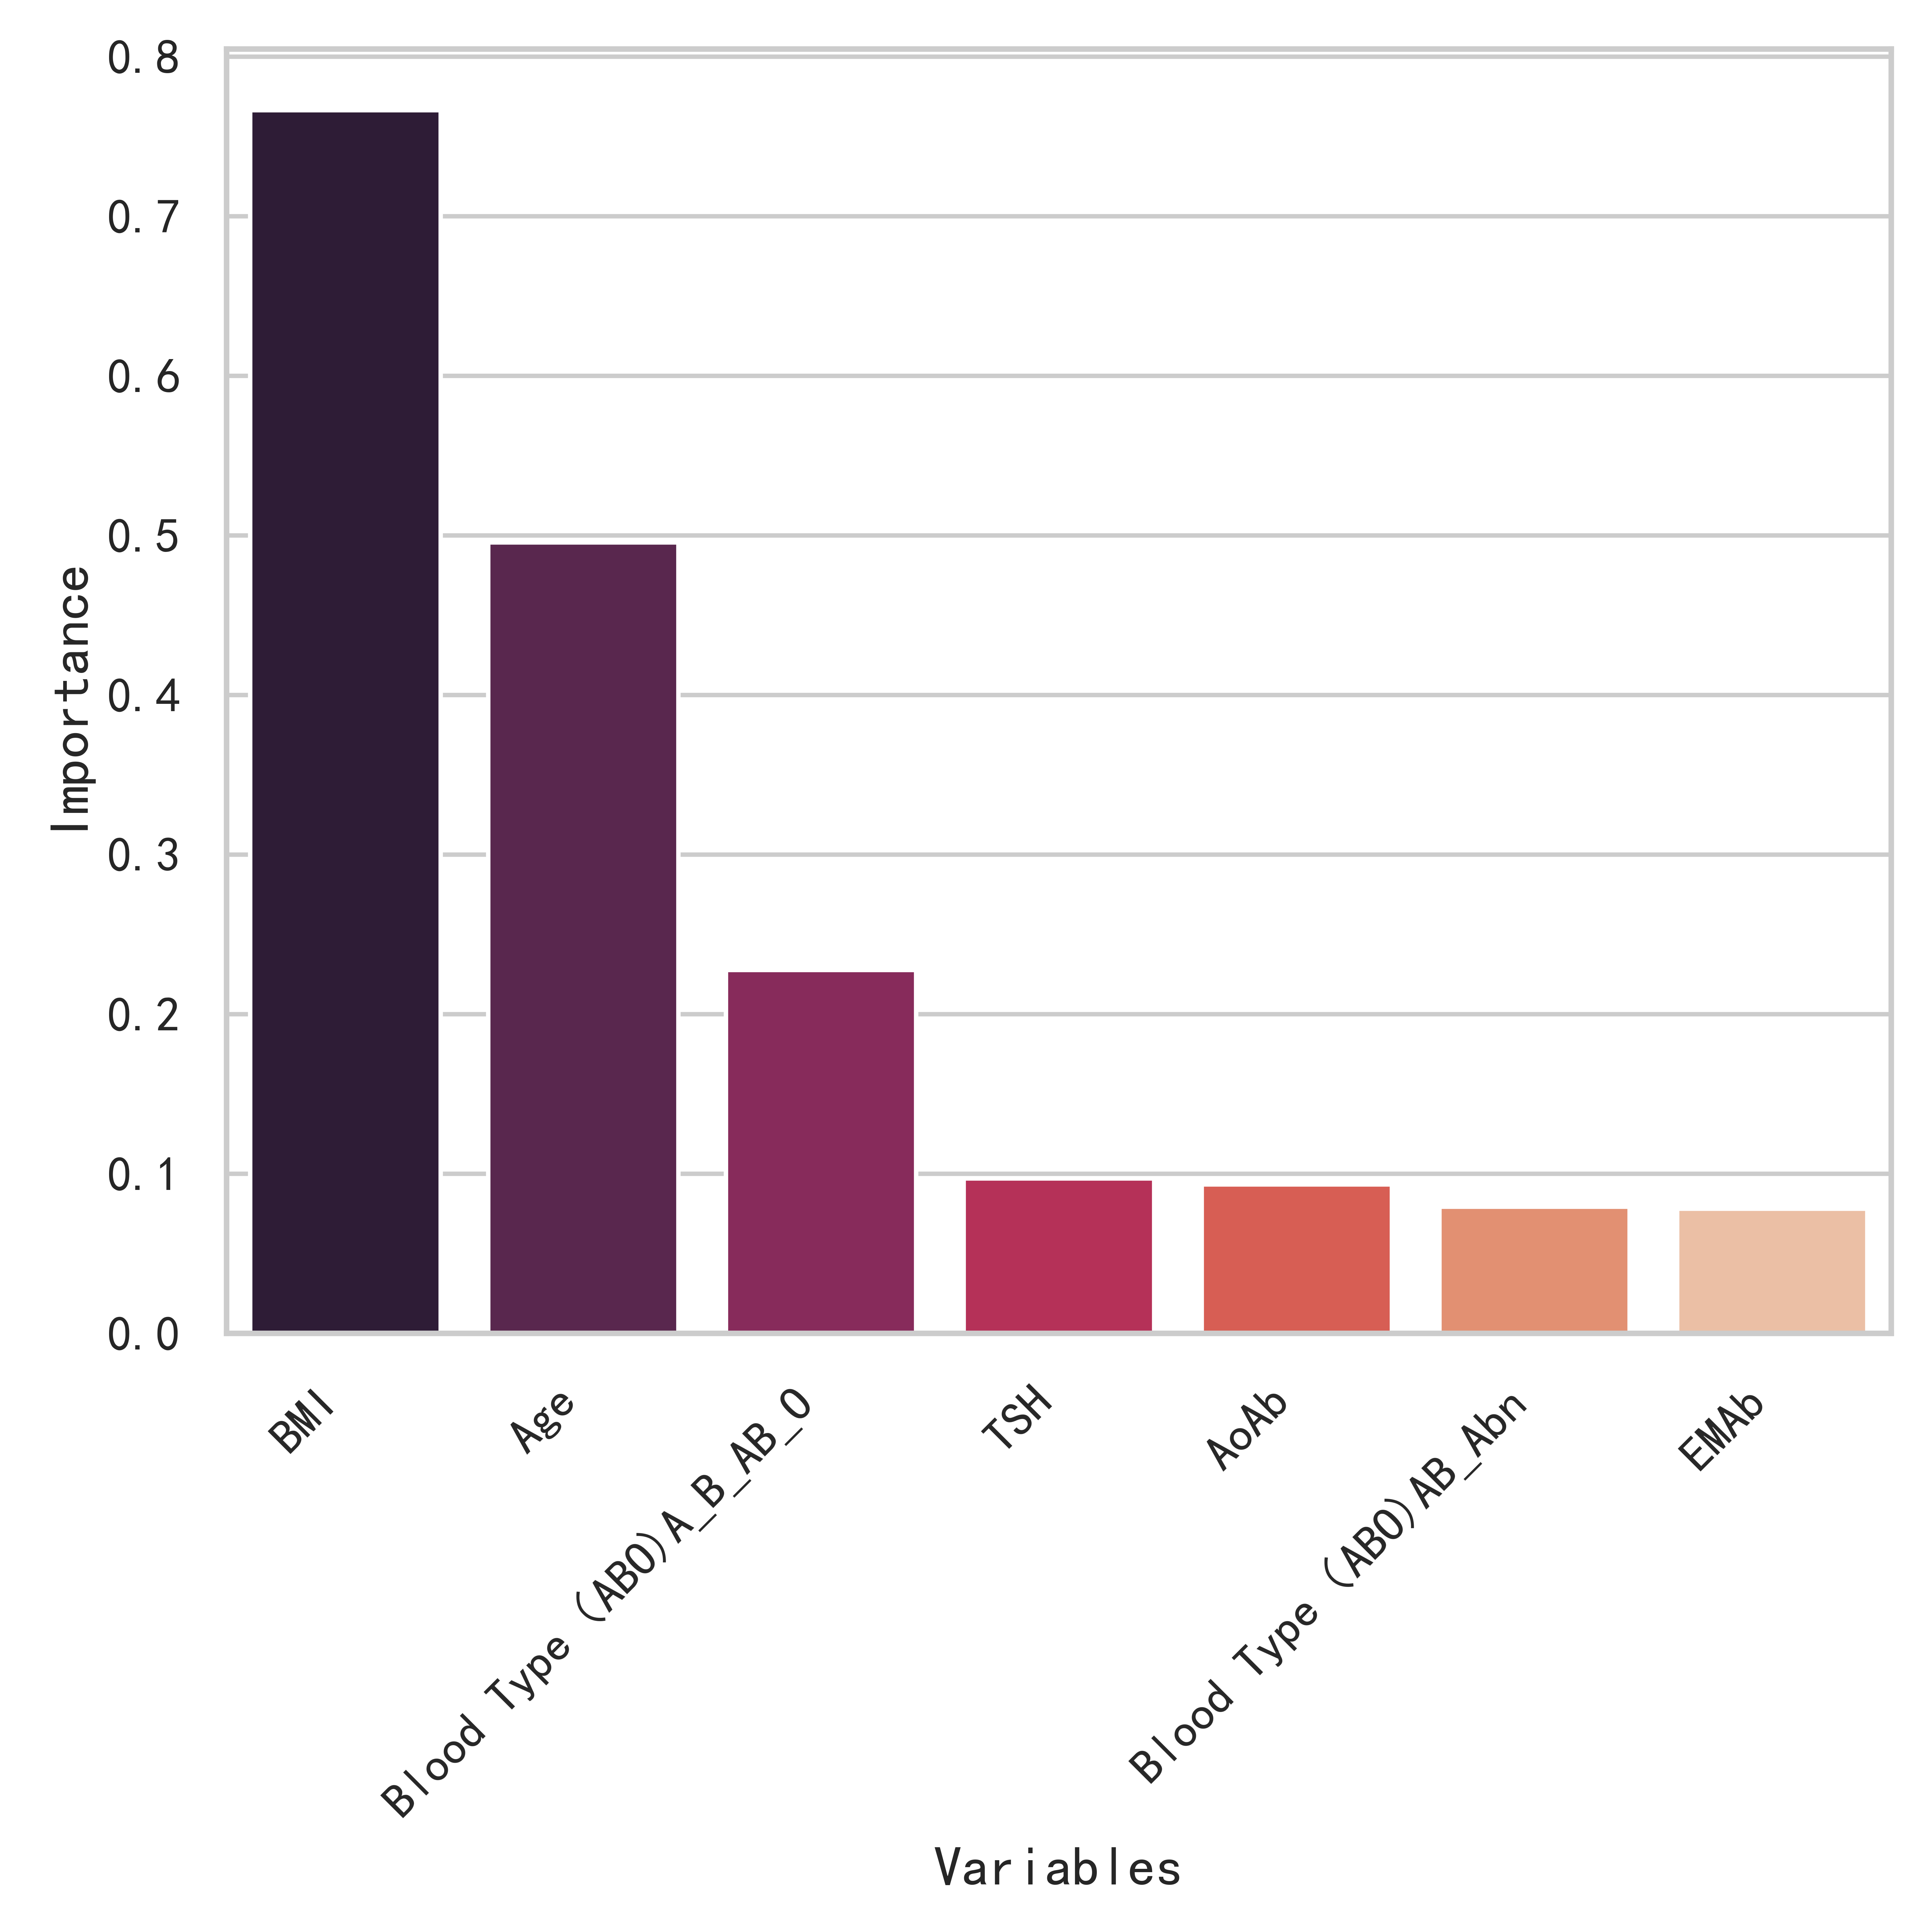

In [9]:
importance_plot=sns.barplot(x="Variables", y="Importance",palette="rocket",data=feature_importance)
importance_plot.set_xticklabels(
    importance_plot.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# plt.show()
plt.tight_layout()
plt.savefig("./Feature Importance.png")
# Image(filename="./paper/Figure_1.png")
# plt.clf()
# plt.close()    


### Generating

In [42]:
print(VAR_NUM)
benchmark_result = pd.DataFrame()
reg_X = []
print(feature_importance)
for i in tqdm(range(len(feature_importance))):
    print(i)
    
    reg_X.append(feature_importance['Variables_name'].values[i])
    print(reg_X)
    
    if not (len(reg_X) in VAR_NUM):
        continue
        print("continue")
        

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
            Variables_name                Variables  Importance
1                      BMI                      BMI    0.766362
0                      Age                      Age    0.495662
5  Blood Type（ABO)A_B_AB_O  Blood Type（ABO)A_B_AB_O    0.227657
2                      TSH                      TSH    0.097113
4                     AoAb                     AoAb    0.093339
6    Blood Type（ABO)AB_Abn    Blood Type（ABO)AB_Abn    0.079421
3                     EMAb                     EMAb    0.078141
0
['BMI']
1
['BMI', 'Age']
2
['BMI', 'Age', 'Blood Type（ABO)A_B_AB_O']
3
['BMI', 'Age', 'Blood Type（ABO)A_B_AB_O', 'TSH']
4
['BMI', 'Age', 'Blood Type（ABO)A_B_AB_O', 'TSH', 'AoAb']
5
['BMI', 'Age', 'Blood Type（ABO)A_B_AB_O', 'TSH', 'AoAb', 'Blood Type（ABO)AB_Abn']
6
['BMI', 'Age', 'Blood Type（ABO)A_B_AB_O', 'TSH', 'AoAb', 'Blood Type（ABO)AB_Abn', 'EMAb']



### Generating

In [38]:
benchmark_result = pd.DataFrame()
reg_X = []
for i in tqdm(range(len(feature_importance))):

    reg_X.append(feature_importance['Variables_name'].values[i])
    if not (len(reg_X) in VAR_NUM):
        continue

    for method in METHODS:
        if method["name"] in COMPARED_METHOD:
            # one_model_result stores the result of a combination of classifier and vars, e.g. 4 variables exgboost performance
            one_model_result = {
                "num": i + 1, # the number of used variables
                "method": method["name"], # the name of classifier
                "external": True, # test set or cross-validation test(validation) set
                "reg_X": json.dumps(reg_X),
            }
            classifier = method["classifier"](**method["hyper_parameters"])
            classifier.fit(X_train[reg_X], y_train)

            # save tmp result for later analysis
            if method["name"]=="XGBoost":
                shap_values = shap.TreeExplainer(classifier).shap_values(X_test[reg_X], y=y_test[y], check_additivity=True)
                with open("./tmp/{}_SHAP_{}.pkl".format(method["name"], len(reg_X)), "wb") as f:
                    pickle.dump([shap_values, X_test[reg_X], reg_X], file=f)

            y_pred_test_external = classifier.predict(X_test[reg_X])
            y_pred_train_external = classifier.predict(X_train[reg_X])

            for k, v in MY_METRICS.items():
                one_model_result[k + "_test"] = v(y_test, y_pred_test_external)
                one_model_result[k + "_train"] = v(y_train, y_pred_train_external)

            # some METHODS dont have auc
            if method["name"] in HAVE_AUC_METHOD:
                y_pred_prob_test_external = classifier.predict_proba(X_test[reg_X])
                y_pred_prob_train_external = classifier.predict_proba(X_train[reg_X])
                # save roc result for later analysis
                with open("./tmp/{}_ROC_{}.pkl".format(method["name"], len(reg_X)), "wb") as f:
                    pickle.dump(roc_curve(y_test, y_pred_prob_test_external[:, 1]), file=f)

                for k, v in {
                    "AUC_macro": partial(roc_auc_score, average="macro"),
                }.items():
                    one_model_result[k + "_test"] = v(y_test, y_pred_prob_test_external[:, 1])
                    one_model_result[k + "_train"] = v(y_train, y_pred_prob_train_external[:, 1])
            benchmark_result = benchmark_result.append(one_model_result, ignore_index=True)

            # CV TEST RESULT
            if RUN_CV_RESULT:
                for j in range(CV_RESULT_REPEAT):
                    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=j * 9)
                    for train_index, test_index in kfold.split(X_train[reg_X], y_train[[y]]):

                        t_X_train, t_X_test = X_train[reg_X].iloc[train_index], X_train[reg_X].iloc[test_index]
                        t_y_train, t_y_test = y_train[[y]].iloc[train_index], y_train[[y]].iloc[test_index]

                        classifier = method["classifier"](**method["hyper_parameters"])
                        classifier.fit(t_X_train, t_y_train)
                        t_y_pred_test_CV = classifier.predict(t_X_test)
                        t_y_pred_train_CV = classifier.predict(t_X_train)

                        one_model_result = {"num": i + 1, "method": method["name"], "external": False, "reg_X": json.dumps(reg_X)}
                        for k, v in MY_METRICS.items():
                            one_model_result[k + "_test"] = v(t_y_test, t_y_pred_test_CV)
                            one_model_result[k + "_train"] = v(t_y_train, t_y_pred_train_CV)
                        if method["name"] in HAVE_AUC_METHOD:
                            t_y_pred_prob_test_CV = classifier.predict_proba(t_X_test)
                            t_y_pred_prob_train_CV = classifier.predict_proba(t_X_train)

                            for k, v in {
                                "AUC_macro": partial(roc_auc_score, average="macro"),
                            }.items():
                                one_model_result[k + "_test"] = v(t_y_test, t_y_pred_prob_test_CV[:, 1])
                                one_model_result[k + "_train"] = v(t_y_train, t_y_pred_prob_train_CV[:, 1])

                        benchmark_result = benchmark_result.append(one_model_result, ignore_index=True)

# too large to display
# display(benchmark_result)
benchmark_result.to_csv(".benchmark.csv")
pivot_benchmark_result=benchmark_result.pivot_table(
    values=
    [
        "AUC_macro_test",
        "F1_weighted_test",
        "Accuracy_test",
        "Sensitivity_test",
        "Specifity_test",
    ],
    aggfunc=[np.mean, np.std],
    columns=["external", "method"],
    index=["num"])
display(pivot_benchmark_result)
pivot_benchmark_result.to_csv(".benchmark_pivot.csv")


[15:50:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

mean                                              \
         AUC_macro_test                                               
external            0.0                                               
method    Decision Tree       LDA  Logistic Random Forest   XGBoost   
num                                                                   
1.0            0.501227  0.530159  0.530159      0.468165  0.508274   
2.0            0.543564  0.588704  0.588697      0.491329  0.564595   
3.0            0.541098  0.594226  0.594315      0.540675  0.555711   
4.0            0.539643  0.600273  0.600148      0.522336  0.556026   
5.0            0.538434  0.602129  0.602039      0.523996  0.559369   
6.0            0.538049  0.602350  0.602507      0.530200  0.559478   
7.0            0.536772  0.600535  0.600780      0.526499  0.556880   

                                                                    ...  \
                                                                    ...   
external           1.0                                              ...   
method   Decision Tree       LDA  Logistic Random Forest   XGBoost  ...   
num                                                                 ...   
1.0           0.495669  0.504871  0.504871      0.567346  0.505668  ...   
2.0           0.586916  0.606890  0.606841      0.590388  0.600498  ...   
3.0           0.561887  0.584229  0.583444      0.551372  0.597676  ...   
4.0           0.580659  0.579346  0.579444      0.558427  0.586585  ...   
5.0           0.580659  0.588879  0.589394      0.567494  0.597149  ...   
6.0           0.580659  0.604142  0.605099      0.581530  0.583223  ...   
7.0           0.580659  0.600596  0.601823      0.553261  0.590131  ...   

                      std                                                   \
         Sensitivity_test                                   Specifity_test   
external              0.0                                              0.0   
method           Logistic Random Forest       SVM   XGBoost  Decision Tree   
num                                                                          
1.0              0.002861      0.039115  0.007684  0.000000       0.031921   
2.0              0.018339      0.044201  0.020121  0.000000       0.072328   
3.0              0.019775      0.042867  0.013685  0.000954       0.068005   
4.0              0.023169      0.044235  0.014054  0.002473       0.067833   
5.0              0.023228      0.042015  0.014445  0.001626       0.067868   
6.0              0.023244      0.038515  0.014783  0.004202       0.071666   
7.0              0.024620      0.037512  0.015462  0.004656       0.071091   

                                                                
                                                                
external                                                        
method         LDA  Logistic Random Forest       SVM   XGBoost  
num                                                             
1.0       0.006611  0.006266      0.055624  0.009898  0.000000  
2.0       0.026580  0.024662      0.054527  0.022451  0.000000  
3.0       0.028832  0.028235      0.051955  0.022828  0.001335  
4.0       0.029397  0.028361      0.048899  0.021938  0.004754  
5.0       0.033158  0.032955      0.049162  0.021786  0.004342  
6.0       0.033281  0.032889      0.054968  0.022285  0.005279  
7.0       0.036183  0.036005      0.047516  0.023033  0.006042  

[7 rows x 87 columns]

In [40]:
for i in [4,7]:
    table=benchmark_result[(benchmark_result.external==1) & (benchmark_result.num==i)].pivot_table(
        values=
        [
            "AUC_macro_test",
            "F1_weighted_test",
            "Accuracy_test",
            "Sensitivity_test",
            "Specifity_test",
        ],
        aggfunc=[np.mean],
        index=["method"])["mean"].T
    table.to_csv("./Table_{}.csv".format({4:4,7:3}[i]))
    display(table)
# slightly different(<1%) with paper because of randomness, but the ranking among methods as well as analysis remain the same

method,Decision Tree,LDA,Logistic,Random Forest,SVM,XGBoost
AUC_macro_test,0.580659,0.579346,0.579444,0.558427,NaN,0.586585
Accuracy_test,0.679157,0.662763,0.667447,0.601874,0.667447,0.662763
F1_weighted_test,0.594066,0.574812,0.577765,0.594738,0.554595,0.528344
Sensitivity_test,0.968198,0.954064,0.961131,0.731449,0.985866,1.000000
Specifity_test,0.111111,0.090278,0.090278,0.347222,0.041667,0.000000


method,Decision Tree,LDA,Logistic,Random Forest,SVM,XGBoost
AUC_macro_test,0.580659,0.600596,0.601823,0.553261,NaN,0.590131
Accuracy_test,0.679157,0.672131,0.674473,0.613583,0.662763,0.665105
F1_weighted_test,0.594066,0.583712,0.585210,0.602393,0.544561,0.537887
Sensitivity_test,0.968198,0.964664,0.968198,0.756184,0.985866,0.996466
Specifity_test,0.111111,0.097222,0.097222,0.333333,0.027778,0.013889
